### Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import *
import seaborn as sns
%matplotlib inline
import  statsmodels.api as sm
import statsmodels.stats.api as sms
from scipy.stats import boxcox

### Load in Data

In [2]:
manatees = pd.read_csv("manatees.csv")

In [3]:
manatees.head()

PowerBoats  ManateeDeaths
0         436             14
1         449             21
2         470             18
3         487             19
4         502             24

### Data Wrangling

In [4]:
#None here

# 1. Test Assumptions

#### test the linear regression assumptions in Python.

#### Testing for Linearity and Normality

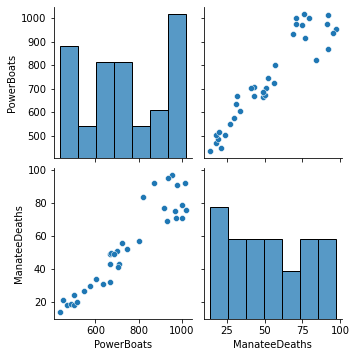

In [6]:
sns.pairplot(manatees)

In [7]:
# see it like this to easily see distribution

C:\Users\lzela\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='PowerBoats', ylabel='Density'>

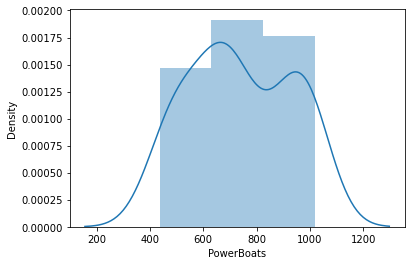

In [8]:
sns.distplot(manatees['PowerBoats'])

In [9]:
# So the above was for powerboats and this one below is for deaths

C:\Users\lzela\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='ManateeDeaths', ylabel='Density'>

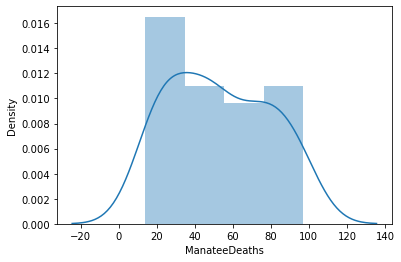

In [10]:
sns.distplot(manatees['ManateeDeaths'])

In [11]:
#### They look roughly normally distributed. Continue.

# 2. Testing for Homoscedasticity

## Create the Basic Model

In [14]:
# You need to assign each of your variables to an x and and a y, since statsmodels does not take full data frames 
#(unlike R). Here's how:

In [15]:
x = manatees['PowerBoats']
y = manatees['ManateeDeaths']

## Let's build the model

In [16]:
model = sm.OLS(y,x).fit()

In [17]:
#Tip!
#You will need to have y and x in that order - no switching them!

# 3. Test for Homoscedasticity

In [18]:
#Unlike R, Python doesn't calculate residuals for you. But it's not too hard. Remember that the residual,
#or error term, is just the true values (your y from your dataset) minus the predicted values your model found. 
#Go ahead and calculate out your residuals:

In [19]:
pred_val = model.fittedvalues.copy()
true_val = manatees['ManateeDeaths'].values.copy()
residual = true_val - pred_val

#### Now that you have your residuals, you can both graph them and run statistical tests on them.
#### How about graphing it first?

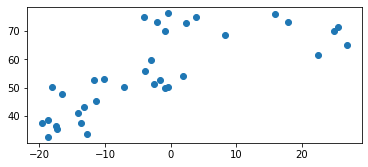

In [20]:
fig, ax = plt.subplots(figsize=(6, 2.5))
_ = ax.scatter(residual, pred_val)

The code above produces a residual plot. You already know from exploration in R that this plot shows some 
heteroscedasticity - just look at how splayed out the dots are, when they should be random and you should be able to 
draw basically a flat horizontal line across.

But what if you wanted to double check your graph with some statistics? statsmodels has a couple different options. 
The first is the Breusch Pagan test you ran in R. You can call the diagnostic.het_breuschpagan function out of the sms 
package. You will feed in your residual variable, then the dataset and the independent variable.

In [23]:
sms.diagnostic.het_breuschpagan(residual, manatees[['PowerBoats']])

(14.786518579352656, nan, 24.8716003560108, 1.7849503580150725e-05)

14.79: This is the lagrange multiplier statistic.
Ignore!

nan: This is the p value for the lagrange multiplier statistic.
Ignore!

24.87: This is the F value to test for homoscedasticity. Like all F values, the bigger it is, the more likely it is to 
be statistically significant.
.0000018: This is the p value to test for homoscedasticity. If it is < .05 (stastically significant), then this means 
you have violated the assumption of homoscedasticity and your data is, in fact, heteroscedastic.

The second test stats models gives us is the Harvey Collier test. Like with our Breusch Pagan test, if the results are 
statistically significant, then you have violated the assumption of homoscedasticity.

In [26]:
sms.linear_harvey_collier(model)

Ttest_1sampResult(statistic=5.479252885631467, pvalue=5.433881942347164e-06)

And again, you have violated our assumption. No surprise!
Here's how to apply the same Box-Cox transformation you did in R to your data in Python. You can simply call the 
boxcox() function:

In [28]:
transformed, _ = boxcox(manatees['PowerBoats'])

Then it's easy to plot your transformed values, to see if they have become more normal (and thus more likely to be 
homoscedastic):

(array([3., 4., 2., 2., 6., 4., 2., 1., 3., 8.]),
 array([ 62.82863549,  67.12464318,  71.42065088,  75.71665857,
         80.01266627,  84.30867396,  88.60468165,  92.90068935,
         97.19669704, 101.49270474, 105.78871243]),
 <BarContainer object of 10 artists>)

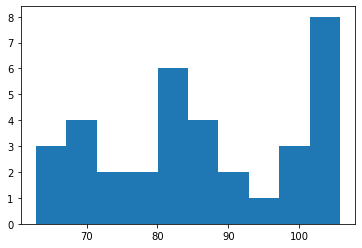

In [30]:
plt.hist(transformed)

As you can see, you still don't have a normal distribution with a beautiful bell curve, so you are unlikely to have 
corrected our hetereoscedasticity. You can also pull these values into a model if you like, and then can re-run your 
tests for homoscedasticity. Just re-assign x as transformed instead of as PowerBoats like so, and 
# create a new model:

In [32]:
x = transformed
model1 = sm.OLS(y,x).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:          ManateeDeaths   R-squared (uncentered):                   0.906
Model:                            OLS   Adj. R-squared (uncentered):              0.903
Method:                 Least Squares   F-statistic:                              328.1
Date:                Wed, 22 Sep 2021   Prob (F-statistic):                    4.88e-19
Time:                        20:07:35   Log-Likelihood:                         -150.84
No. Observations:                  35   AIC:                                      303.7
Df Residuals:                      34   BIC:                                      305.2
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.6411      0.035     18.113      0.000       0.569       0.713
==============================================================================
Omnibus:                        3.678   Durbin-Watson:                   0.455
Prob(Omnibus):                  0.159   Jarque-Bera (JB):                2.425
Skew:                           0.454   Prob(JB):                        0.297
Kurtosis:                       2.085   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Then create new residual values:

In [36]:
pred_val = model1.fittedvalues.copy()
true_val = manatees['ManateeDeaths'].values.copy()
residual = true_val - pred_val

You could also re-test using the Breusch Pagan or the Harvey Collier, but since you already know your data hasn't been fixed, you'll skip this step in Python.

# 4. Testing for Multicollinearity

If you had more independent variables, you would need to test for multicollinearity. This is easy to do in Python, by asking for all correlations between variables in the dataset. You typically call this a correlation matrix. If you're a pure numbers person, the correlation matrix is available in table form. You'll just call the .corr() function after the dataset name like this:

In [37]:
manatees.corr()

PowerBoats  ManateeDeaths
PowerBoats       1.000000       0.937637
ManateeDeaths    0.937637       1.000000

<AxesSubplot:>

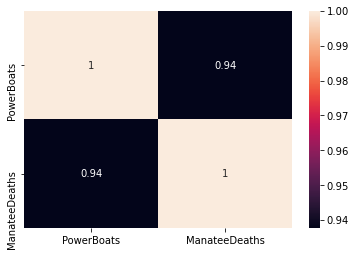

In [38]:
sns.heatmap(manatees.corr(), annot=True)

# 5. Screening for Outliers

In Python, you can easily create a plot that will test for influential data points (those that are outliers in both x and y space) by looking at leverage and studentized deleted residuals at the same time.

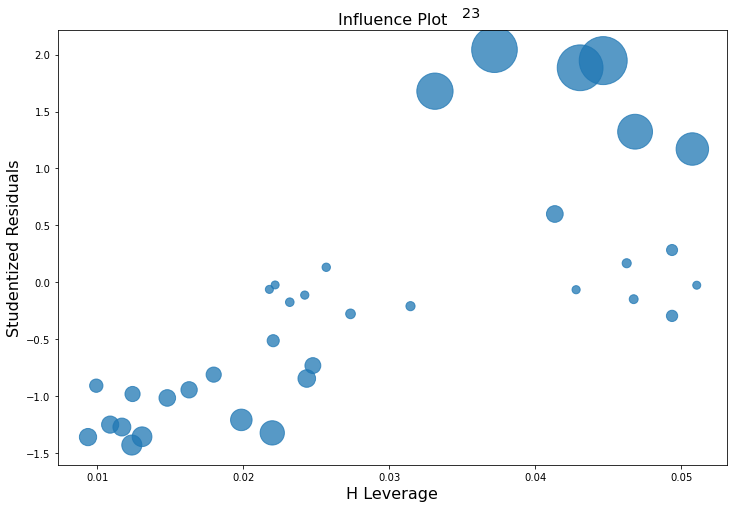

In [39]:
fig, ax = plt.subplots(figsize=(12,8))
fig = sm.graphics.influence_plot(model, alpha = .05, ax = ax, criterion="cooks")

The larger the dot on this plot, the more likely something is to be an outlier. However, something is only officially an outlier when it has a row number next to it. In this case, you don't have any studentized deleted residuals bigger than 2.5-3, and your leverage values aren't bigger than .5, which would indicate a major problem, so you're good to go.

Just to give you an example of what it will look like when you have influential outliers, here's a graph of the dataset with outliers artifically added in:

See how row numbers 36 and 37 stick out like a sore thumb and are labeled? Those would be outliers to remove.

But back to your real data. If you'd rather look via table instead of a graph, just to double check the values, you can:

In [40]:
infl = model.get_influence()
print(infl.summary_frame())

    dfb_PowerBoats   cooks_d  standard_resid  hat_diag  dffits_internal  \
0        -0.132313  0.017079       -1.344190  0.009364        -0.130685   
1        -0.091052  0.008333       -0.911488  0.009930        -0.091285   
2        -0.131236  0.016941       -1.240967  0.010881        -0.130158   
3        -0.138372  0.018804       -1.261270  0.011682        -0.137128   
4        -0.110133  0.012142       -0.982851  0.012413        -0.110190   
5        -0.160086  0.024862       -1.409258  0.012364        -0.157676   
6        -0.156233  0.023818       -1.341372  0.013064        -0.154330   
7        -0.124618  0.015514       -1.016502  0.014792        -0.124555   
8        -0.121656  0.014847       -0.946983  0.016286        -0.121846   
9        -0.109841  0.012187       -0.816096  0.017970        -0.110396   
10       -0.172217  0.029260       -1.201621  0.019862        -0.171055   
11       -0.009384  0.000091       -0.063826  0.021783        -0.009524   
12       -0.017788  0.000

The DFBETAS value is shown in the dfb_PowerBoats column, and if any value is greater than 1, then you have a problem with an influential value.

The DFFITS value is shown in the dffits column, and like DFBETAS, if you have a value greater than 1, this indicates a problem.

Leverage values are shown in the hat_diag column, and if a value is in the .2 - .5 range, you may have a moderate outlier problem, and if it is over .5, then you have a large outlier problem.

Studentized deleted residuals are shown in the student_resid column, and if you have a value over 2.5 or 3, you probably have an outlier problem.

# Interpreting the Regression Output

# 1. To call up the summary of your regression model, which has all the statistics you could ever want and need, you will simply use its name and .summary().

In [41]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:          ManateeDeaths   R-squared (uncentered):                   0.945
Model:                            OLS   Adj. R-squared (uncentered):              0.943
Method:                 Least Squares   F-statistic:                              584.4
Date:                Wed, 22 Sep 2021   Prob (F-statistic):                    5.35e-23
Time:                        20:24:39   Log-Likelihood:                         -141.48
No. Observations:                  35   AIC:                                      285.0
Df Residuals:                      34   BIC:                                      286.5
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
PowerBoats     0.0750      0.003     24.174      0.000       0.069       0.081
==============================================================================
Omnibus:                        4.022   Durbin-Watson:                   0.782
Prob(Omnibus):                  0.134   Jarque-Bera (JB):                3.676
Skew:                           0.775   Prob(JB):                        0.159
Kurtosis:                       2.660   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

You find your overall F value under F-Statistic in the righthand column, and underneath is the p value. The overall model is statistically significant, because the p value is less that .05, so you can then move on to interpreting other things. You have your slope under coef in the middle table, as well as the associated t test and and p value for the significance of this particular independent variable in your model. Because the p value is < .05, you can determine that PowerBoats has a significant effect on the number of manatee deaths. By looking at the R-squared and Adj. R-squared in the upper right hand corner, you see that this model accounts for 94% of the variance in explaining manatee deaths.

The last table also provides some model fit indices:

Omnibus: This is a test of skew and kurtosis of the residual. You want a value close to zero, which would indicate normality.
Prob(Omnibus): This is a test indicating the probabilty that residulas are normally distributed. You would like to see a value close to zero here, to inidcate a normal distribution.
Skew: Again, you would like to see a value close to zero, and this result feeds into the Omnibus test discussed above.
Kurtosis: If you have a value close to zero, this means our data is relatively normal.
Durbin-Watson: This also tests for homoscedasticity! You would like a value between 1 and 2, otherwise you have the presence of heteroscedasticity within your data.
Jarque-Bera (JB): This also tests skew and kurtosis. It should also be close to zero.
Prob (JB): The probabilty that JB is normal. You would like this to be close to zero as well.
Condition Number: You would like to see a condition number below 30 or so, becasue that indicates low multicollinearity. If you have higher than 30, it's time to suspect related variables!
Now that you understand what these model fit indices are, you can see that:

You have failed the omnibus and Jarque-Bera, probably because your kurtosis is too high
You have failed the Durbin-Watson, so you have heteroscedasticity in your data
You have no multicollinearity - which is expected since you only have one independent variable!

# Summary

In statistics, you write the linear regression equation as y = b1x + b0 where b0 is the y-intercept of the line and b1 is the slope of the line.

Linear regression allows you to predict values of y for a given x. This is done by first calculating the coefficients b0 and b1 and then plugging in the desired value of x and solving for y.

The independent variable (x) is the variable that is not affected by what happens to the other variable.

The dependent variable (y) is the variable that is affected by what happens to the other variable. It depends on the independent variable. For example, in the correlation between the number of powerboats and the number of manatee deaths, the number of deaths is affected by the number of powerboats in the water, but not the other way around. So, you would assign x to represent the number of powerboats and y to represent the number of manatee deaths.

The true linear regression line is y = β1x + β0 where β0 is the true y-intercept of the line and β1 is the true slope of the line.

A residual is the difference between the observed value of y for a given x and the predicted value of y on the regression line for the same x.

To check all the assumptions for linear regression, you will need to create a scatterplot of x and y, a residual plot, and a Q-Q plot of the residuals.

To conduct a hypothesis test to determine whether there is a linear relationship between two variables, test the slope (β1) to see whether it is equal to zero.

The appropriate hypotheses for this test are: H0: β1 = 0 and Ha: β1 ≠ 0